Visualizing outliers with boxplots

In this recipe, we will identify outliers using boxplots. Boxplots produce a box that encloses the observations within the 75th and 25th quantiles, or in other words, within the Inter-Quartile Range (IQR).

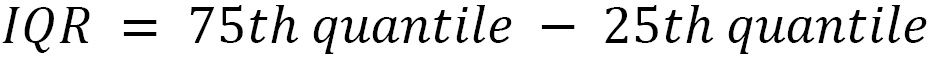

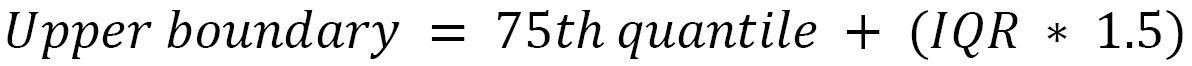

In [28]:
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np

sns.set(style="darkgrid")

from sklearn.datasets import fetch_california_housing

In [2]:
X, y = fetch_california_housing(return_X_y=True, as_frame=True)

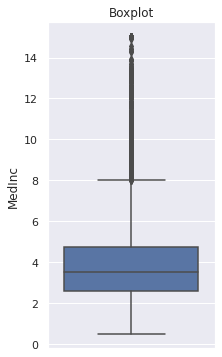

In [3]:
plt.figure(figsize=(3,6))

sns.boxplot(y=X["MedInc"])

plt.title("Boxplot")

plt.show()

In [10]:
def plot_boxplot_and_hist(data,variable):
    f,(ax_box,ax_hist) = plt.subplots(2,sharex=True,gridspec_kw={"height_ratios":(0.50,0.85)})
    sns.boxplot(x=data[variable],ax=ax_box)
    sns.histplot(data=data,x=variable,ax=ax_hist)
    ax_box.set(xlabel='')
    plt.title(variable)
    plt.show()
    

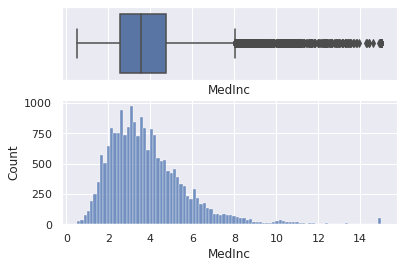

In [11]:
plot_boxplot_and_hist(X,"MedInc")

In [18]:
#finding outliers using the mean and standard devation

from sklearn.datasets import load_breast_cancer

breast_cancer = load_breast_cancer()

X= pd.DataFrame(breast_cancer.data,columns=breast_cancer.feature_names)


#reate a function that returns the mean plus and minus fold 
#times the standard deviation, where fold is a parameter to the function
def find_limits(df,variable,fold):
    lower_limit =df[variable].mean() - fold * df[variable].std()
    upper_limit =df[variable].mean() + fold * df[variable].std()
    return lower_limit ,upper_limit 

In [34]:
lower_limit,upper_limit = find_limits(X,"mean smoothness",3)

outliers = np.where((X["mean smoothness"] > upper_limit) | (X["mean smoothness"] < lower_limit),True,False)


outliers.sum()

"""If we now execute outliers.sum(), we will see the value 5, indicating that there are five outliers or observations that are smaller or greater than the extreme values found with the mean and the standard deviation."""

'If we now execute outliers.sum(), we will see the value 5, indicating that there are five outliers or observations that are smaller or greater than the extreme values found with the mean and the standard deviation.'

# Finding outliers with the interquartile range proximity rule

If the variables are not normally distributed variables, we can identify outliers utilizing the IQR proximity rule. According to the IQR rule, data points that fall below the 25th quantile - 1.5 times the IQR, or beyond the 75th quantile + 1.5 times the IQR, are outliers.

In [41]:
X,y  = fetch_california_housing(return_X_y=True,as_frame=True)


#using quantiles range
#create a function that returns the 25th quantile - 1.5 times the IQR, or the 75th quantile + 1.5 times the IQR
def find_limits(df,variable,fold):
    IQR = df[variable].quantile(0.75)-df[variable].quantile(0.25)
    lower_limit = df[variable].quantile(0.25) - (IQR *fold)
    upper_limit = df[variable].quantile(0.75) +(IQR *fold)
    return lower_limit , upper_limit 

#use the fucntion to capture the extreme limits of the MEDinc varaible 
lower_limit, upper_limit = find_limits(X, "MedInc", 3)

outliers = np.where((X["MedInc"] > upper_limit) |(X["MedInc"] < lower_limit),True,False,)

outliers.sum()

140

Removing outliers

Trimming, or truncating, is the process of removing observations with outliers in one or more variables in the dataset. There are three commonly used methods to set the boundaries beyond which a value can be considered an outlier. If the variable is normally distributed, the boundaries are given by the mean plus or minus three times the standard deviation, as approximately 99% of the data will be distributed between those limits. For normally as well as not normally distributed variables, we can determine the limits using the IQR proximity rule or by directly setting the limits to the 5th and 95th quantiles. In this recipe, we are going to use the IQR proximity rule to identify and then remove outliers, using pandas, and then we will automate this process for multiple variables, utilizing Feature-engine

In [2]:
from sklearn.datasets import fetch_california_housing

from sklearn.model_selection import train_test_split

from feature_engine.outliers import OutlierTrimmer

In [8]:
X, y = fetch_california_housing(return_X_y=True, as_frame=True)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0,)


trimmer = OutlierTrimmer(variables = ["MedInc", "HouseAge", "Population"],
                         capping_method="iqr",tail="both",fold=1.5,)

"""By executing trimmer.left_tail_caps_, we can visualize the lower limits for the three variables: {'MedInc': -0.6776500000000012, 'HouseAge': -10.5, and 'Population': -626.0}. By executing trimmer.right_tail_caps_, we can see the upper limits for those variables: {'MedInc': 7.984350000000001, 'HouseAge': 65.5, and 'Population': 3134.0}"""
trimmer.fit(X_train)


X_train_enc = trimmer.transform(X_train)

X_test_enc = trimmer.transform(X_test)



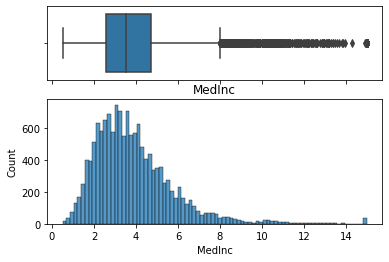

In [12]:
#let me expalin the plot using both varation
import matplotlib.pyplot as plt

import seaborn as sns

def plot_boxplot_and_hist(data, variable):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios":(0.50, 0.85)})
    sns.boxplot(x=data[variable], ax=ax_box)
    sns.histplot(data=data, x=variable, ax=ax_hist)
    ax_box.set(xlabel="")
    plt.title(variable)
    plt.show()
    
plot_boxplot_and_hist(X_train, "MedInc")

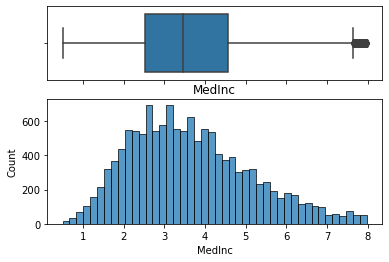

In [13]:
plot_boxplot_and_hist(X_train_enc, "MedInc")

#Capping or censoring outliers
Capping or censoring is the process of transforming the data by limiting the extreme values, as in the outliers, to a certain maximum or minimum arbitrary value. With this procedure, the outliers are not removed but are instead replaced by other values. A typical strategy involves setting outliers to a specified percentile. For example, we can set all data below the 5th percentile to the value at the 5th percentile and all data greater than the 95th percentile to the value at the 95th percentile. Alternatively, we can cap the variable at the limits determined by the IQR proximity rule or at the mean plus and minus three times the standard deviation. In this recipe, we will cap variables at arbitrary values determined by the mean plus and minus three times the standard deviation using pandas and Feature-engine.

In [25]:
import numpy as np

import pandas as pd

from sklearn.datasets import load_breast_cancer

from sklearn.model_selection import train_test_split

from feature_engine.outliers import Winsorizer

In [27]:
breast_cancer = load_breast_cancer()


X = pd.DataFrame(breast_cancer.data,columns=breast_cancer.feature_names)

y = breast_cancer.target

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,
                                                    random_state=0)

In [29]:
#set up a transformer to cap two variables at the limits determined with the mean and standard deviation

capper = Winsorizer(variables=["worst smoothness", "worst texture"],
                    capping_method="gaussian",tail="both",fold=3,)

capper.fit(X_train)

Winsorizer(tail='both', variables=['worst smoothness', 'worst texture'])

By executing capper.left_tail_caps_, we can visualize the lower limits for the three variables: {'worst smoothness': 0.06356074164705164, 'worst texture': 7.092123638591499}. By executing capper.right_tail_caps_, we can see the upper limits for those variables: {'worst smoothness': 0.20149734880520967, 'worst texture': 43.97692158753917}

In [31]:
X_train = capper.transform(X_train)
X_test = capper.transform(X_test)

X_train[capper.variables_].max()

worst smoothness     0.201411
worst texture       43.953738
dtype: float64

In [37]:
import pandas as pd
from sklearn.datasets import load_breast_cancer
from feature_engine.outliers import ArbitraryOutlierCapper

# Load the breast cancer dataset
breast_cancer = load_breast_cancer()
X = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)

# Instantiate the ArbitraryOutlierCapper
aoc = ArbitraryOutlierCapper(
    max_capping_dict={
        "mean radius": 20.0,
        "mean texture": 25.0,
        # Add more column names and their corresponding maximum caps if needed
    },
    min_capping_dict={
        "mean radius": 5.0,
        "mean texture": 10.0,
        # Add more column names and their corresponding minimum caps if needed
    }
)

# Fit the capper to the data
aoc.fit(X)

# Transform the data by capping the outliers
X_transformed = aoc.transform(X)



Capping outliers using quantiles

When capping outliers, we clip the variable extreme values to a certain maximum or minimum value determined by some statistical parameter. A typical strategy involves setting outliers to a specified percentile. For example, we can set all data below the 5th percentile to the value at the 5th percentile and all data greater than the 95th percentile to the value at the 95th percentile. In this recipe, we will cap variables at arbitrary values determined by the percentiles using pandas and Feature-engine

In [38]:
import pandas as pd

from sklearn.datasets import load_breast_cancer

from sklearn.model_selection import train_test_split

from feature_engine.outliers import Winsorizer

In [43]:
capper = Winsorizer(

        variables = ["worst smoothness", "worst texture"],

        capping_method="quantiles",

        tail="both",

        fold=0.05,

)

capper.fit(X_train)

capper.left_tail_caps_


{'worst smoothness': 0.0960535, 'worst texture': 16.7975}

In [47]:
X_train = capper.transform(X_train)

X_test = capper.transform(X_test)

X_train[capper.variables_].max()

worst smoothness     0.173215
worst texture       36.277500
dtype: float64